## Real or Fake Job Classification

###  - with combination of text features and numerical features

In this notebook, we're going to analyze the Real or Fake Job dataset which can be found in https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction. The dataset contains 800 fake jobs out of 17K job descriptions and can be used to create classification models with KNN and Logistic Regression algorithm. 

The project was completed as part of Computer Science's 'Data Science' course on Universitas Indonesia.

### EDA

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt


job_df = pd.read_csv('fake_job_postings.csv', index_col=0)
job_df.head(10)

,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
job_id,,,,,,,,,,,,,,,,,
1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
6,Accounting Clerk,"US, MD,",NaN,NaN,NaN,Job OverviewApex is an environmental consultin...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,0
7,Head of Content (m/f),"DE, BE, Berlin",ANDROIDPIT,20000-28000,"Founded in 2009, the Fonpit AG rose with its i...",Your Responsibilities: Manage the English-spea...,Your Know-How: ...,Your Benefits: Being part of a fast-growing co...,0,1,1,Full-time,Mid-Senior level,Master's Degree,Online Media,Management,0
8,Lead Guest Service Specialist,"US, CA, San Francisco",NaN,NaN,Airenvy’s mission is to provide lucrative yet ...,Who is Airenvy?Hey there! We are seasoned entr...,"Experience with CRM software, live chat, and p...",Competitive Pay. You'll be able to eat steak e...,0,1,1,NaN,NaN,NaN,NaN,NaN,0
9,HP BSM SME,"US, FL, Pensacola",NaN,NaN,Solutions3 is a woman-owned small business who...,Implementation/Configuration/Testing/Training ...,MUST BE A US CITIZEN.An active TS/SCI clearanc...,NaN,0,1,1,Full-time,Associate,NaN,Information Technology and Services,NaN,0


In [2]:
import pandas_profiling as pp
pp.ProfileReport(job_df)

#### key insight:
- This dataset has 17880 observations with 17 features (exclude job_id) 
- mostly text value
- salary_range feature has the most null values
- ordinal data features don't have missing values
- have imbalance data target (fraudulent cases). 

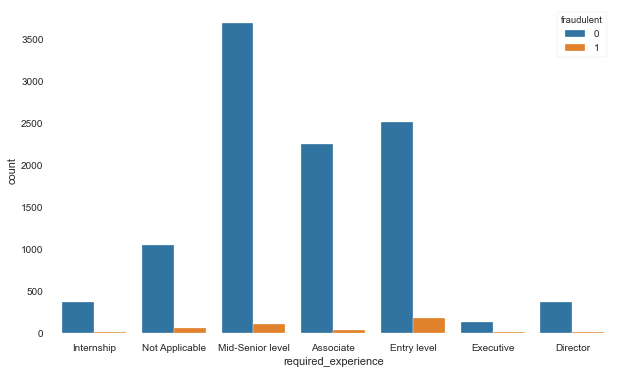

In [3]:
plt.figure(figsize = (10, 6))

ax = sns.countplot(x='required_experience', hue='fraudulent',data=job_df)

#### key insight:
- fraudulent cases more likely required experience on entry and mid-senior level, similar to real posting, but more on mid-senior level side.

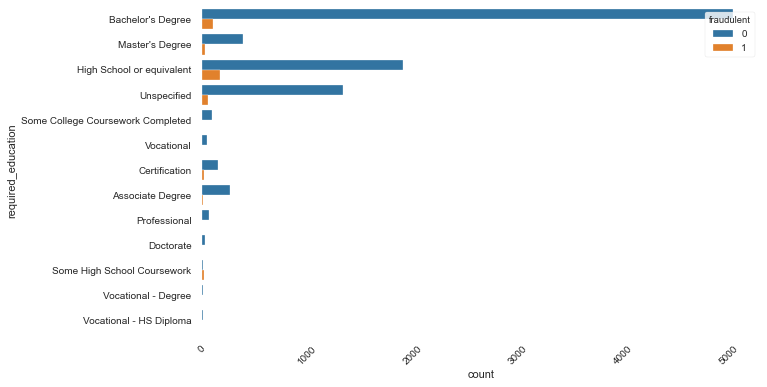

In [4]:
plt.figure(figsize=(10,6))
sns.countplot(hue='fraudulent',y='required_education',data=job_df)
plt.xticks(rotation=45)
plt.show()

#### key insight:
- job_posting with required_education 'High school or equivalent' has the most fraudulent cases.

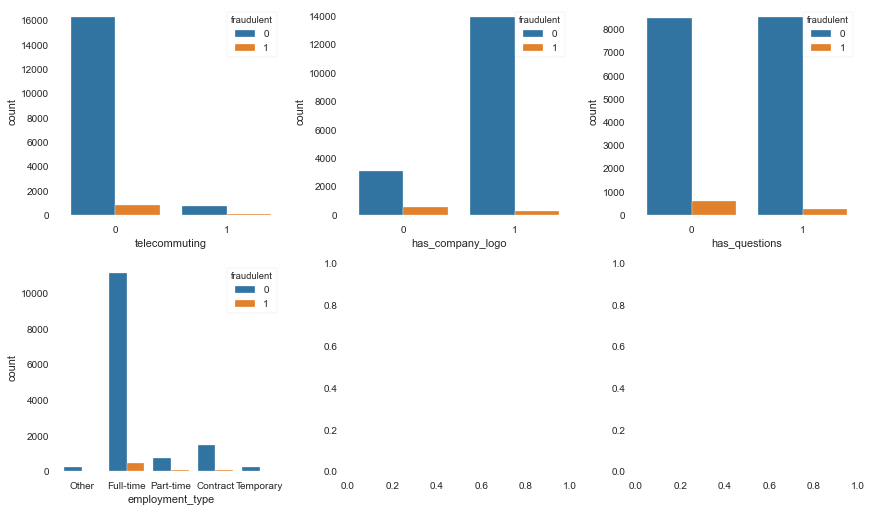

In [5]:
ord_df = job_df.copy()
ord_vars = ['telecommuting', 'has_company_logo', 'has_questions', 'employment_type']
num_plots = len(ord_vars)
total_cols = 3
total_rows = num_plots//total_cols + 1
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(4*total_cols, 7), constrained_layout=True)
for i, var in enumerate(ord_vars):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.countplot(hue =ord_df['fraudulent'], x=var, data=ord_df, ax=axs[row][pos])

#### key insight:
- fraudulent and real job postings are more likely not a telecommuting position
- fraudulent cases are more likely don't have company logo, unlike real job postings
- fraudulent cases are more likely don't have screening question, while real job postings have equal mix of either have question or not.
- fraudulent cases more likely to happen on employment_type with 'Full-time' value. 

### Data Cleaning

In [6]:
#missing values in salary_range are quiet large in both fraud or real job postings.
# delete 'salary_range'
job_df = job_df.drop('salary_range', axis='columns')

In [7]:
# suppose we already traced the data briefly and we found some "#NAME?" values and wondering how many are these value in our data
job_df.isin(['#NAME?']).sum(axis=0)

title                   0
location                0
department              0
company_profile         0
description             8
requirements           36
benefits               30
telecommuting           0
has_company_logo        0
has_questions           0
employment_type         0
required_experience     0
required_education      0
industry                0
function                0
fraudulent              0
dtype: int64

In [8]:
# delete it
job_df.drop(job_df[(job_df.description == '#NAME?') |
                   (job_df.requirements == '#NAME?') |
                   (job_df.benefits == '#NAME?') ].index, inplace=True)

This dataset has many missing values in some features. However, since the dataset is heavily imbalance, I avoided dropping more values to keep the fraud data no less. To make this up, I fill missing values with blank space and combine each text value into one new feature.

In [9]:
#fill missing values with blank space
job_df.fillna(' ',inplace=True)

In [10]:
# concat features that has text values
job_df['text'] = job_df['title'].str.cat(job_df[['title', 'location', 'department','company_profile','description',
                                                 'requirements', 'benefits','employment_type','required_education','industry',
                                                    'function']].astype(str), sep=' ')

In [11]:
print(job_df['text'][10])
type(job_df['text'].values)

Customer Service Associate - Part Time  Customer Service Associate - Part Time  US, AZ, Phoenix   Novitex Enterprise Solutions, formerly Pitney Bowes Management Services, delivers innovative document and communications management solutions that help companies around the world drive business process efficiencies, increase productivity, reduce costs and improve customer satisfaction. For almost 30 years, clients have turned to us to integrate and optimize their enterprise-wide business processes to empower employees, increase productivity and maximize results. As a trusted partner, we continually focus on delivering secure, technology-enabled document and communications solutions that improve our clients' work processes, enhance their customer interactions and drive growth. The Customer Service Associate will be based in Phoenix, AZ. The right candidate will be an integral part of our talented team, supporting our continued growth.Responsibilities:Perform various Mail Center activities (

numpy.ndarray

In [12]:
job_df = job_df.drop(columns=['title', 'location', 'department','company_profile','description','requirements', 'benefits','employment_type',
                 'required_education','industry', 'function', 'required_experience'])

In [13]:
job_df

,telecommuting,has_company_logo,has_questions,fraudulent,text
job_id,,,,,
1,0,1,0,0,"Marketing Intern Marketing Intern US, NY, New ..."
2,0,1,0,0,Customer Service - Cloud Video Production Cust...
3,0,1,0,0,Commissioning Machinery Assistant (CMA) Commis...
4,0,1,0,0,Account Executive - Washington DC Account Exec...
5,0,1,1,0,"Bill Review Manager Bill Review Manager US, FL..."
...,...,...,...,...,...
17876,0,1,1,0,Account Director - Distribution Account Direc...
17877,0,1,1,0,"Payroll Accountant Payroll Accountant US, PA, ..."
17878,0,0,0,0,Project Cost Control Staff Engineer - Cost Con...


### Text Normalization

In [14]:
import re
import string

def clean_text(text):    
    #lower the case
    text = text.lower()

    #remove punctuation
    text = text.translate(str.maketrans('','', string.punctuation))

    #remove HTML & links
    text = re.sub('<.*?>+', '', text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)

    #remove extra whitespace
    text = text.strip()
    
    return text

In [15]:
job_df['text'] = job_df['text'].apply(lambda p: clean_text(p))

In [16]:
print(job_df['text'][10])

customer service associate  part time  customer service associate  part time  us az phoenix   novitex enterprise solutions formerly pitney bowes management services delivers innovative document and communications management solutions that help companies around the world drive business process efficiencies increase productivity reduce costs and improve customer satisfaction for almost 30 years clients have turned to us to integrate and optimize their enterprisewide business processes to empower employees increase productivity and maximize results as a trusted partner we continually focus on delivering secure technologyenabled document and communications solutions that improve our clients work processes enhance their customer interactions and drive growth the customer service associate will be based in phoenix az the right candidate will be an integral part of our talented team supporting our continued growthresponsibilitiesperform various mail center activities sorting metering folding 

In [17]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

stop_words = stopwords.words('english')

# remove stop words(e.g. 'the', 'a', 'an') in text
job_df['text'] = job_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
print(job_df['text'])

job_id
1        marketing intern marketing intern us ny new yo...
2        customer service cloud video production custom...
3        commissioning machinery assistant cma commissi...
4        account executive washington dc account execut...
5        bill review manager bill review manager us fl ...
                               ...                        
17876    account director distribution account director...
17877    payroll accountant payroll accountant us pa ph...
17878    project cost control staff engineer cost contr...
17879    graphic designer graphic designer ng la lagos ...
17880    web application developers web application dev...
Name: text, Length: 17811, dtype: object


In [18]:
print(job_df['text'][10])

customer service associate part time customer service associate part time us az phoenix novitex enterprise solutions formerly pitney bowes management services delivers innovative document communications management solutions help companies around world drive business process efficiencies increase productivity reduce costs improve customer satisfaction almost 30 years clients turned us integrate optimize enterprisewide business processes empower employees increase productivity maximize results trusted partner continually focus delivering secure technologyenabled document communications solutions improve clients work processes enhance customer interactions drive growth customer service associate based phoenix az right candidate integral part talented team supporting continued growthresponsibilitiesperform various mail center activities sorting metering folding inserting delivery pickup etclift heavy boxes files paper neededmaintain highest levels customer care demonstrating friendly coope

In [19]:
#converting words to its base form with considering the context
from nltk import pos_tag
lemmatizer = WordNetLemmatizer() 

# part-of-speech tag
def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def lemmatize_words(text):
    final_text = []
    for i in text.split():
        if i.strip() not in stop_words:
            pos = pos_tag([i.strip()])
            word = lemmatizer.lemmatize(i.strip(),get_simple_pos(pos[0][1]))
            final_text.append(word)
    return " ".join(final_text)      


job_df.text = job_df.text.apply(lemmatize_words)

In [20]:
print(job_df['text'][10])

customer service associate part time customer service associate part time u az phoenix novitex enterprise solution formerly pitney bowes management service delivers innovative document communication management solution help company around world drive business process efficiency increase productivity reduce cost improve customer satisfaction almost 30 year client turn u integrate optimize enterprisewide business process empower employee increase productivity maximize result trust partner continually focus deliver secure technologyenabled document communication solution improve client work process enhance customer interaction drive growth customer service associate base phoenix az right candidate integral part talented team support continued growthresponsibilitiesperform various mail center activity sort meter fold insert delivery pickup etclift heavy box file paper neededmaintain high level customer care demonstrate friendly cooperative attitudedemonstrate flexibility satisfy customer d

In [21]:
print(job_df['text'])

job_id
1        marketing intern marketing intern u ny new yor...
2        customer service cloud video production custom...
3        commission machinery assistant cma commission ...
4        account executive washington dc account execut...
5        bill review manager bill review manager u fl f...
                               ...                        
17876    account director distribution account director...
17877    payroll accountant payroll accountant u pa phi...
17878    project cost control staff engineer cost contr...
17879    graphic designer graphic designer ng la lagos ...
17880    web application developer web application deve...
Name: text, Length: 17811, dtype: object


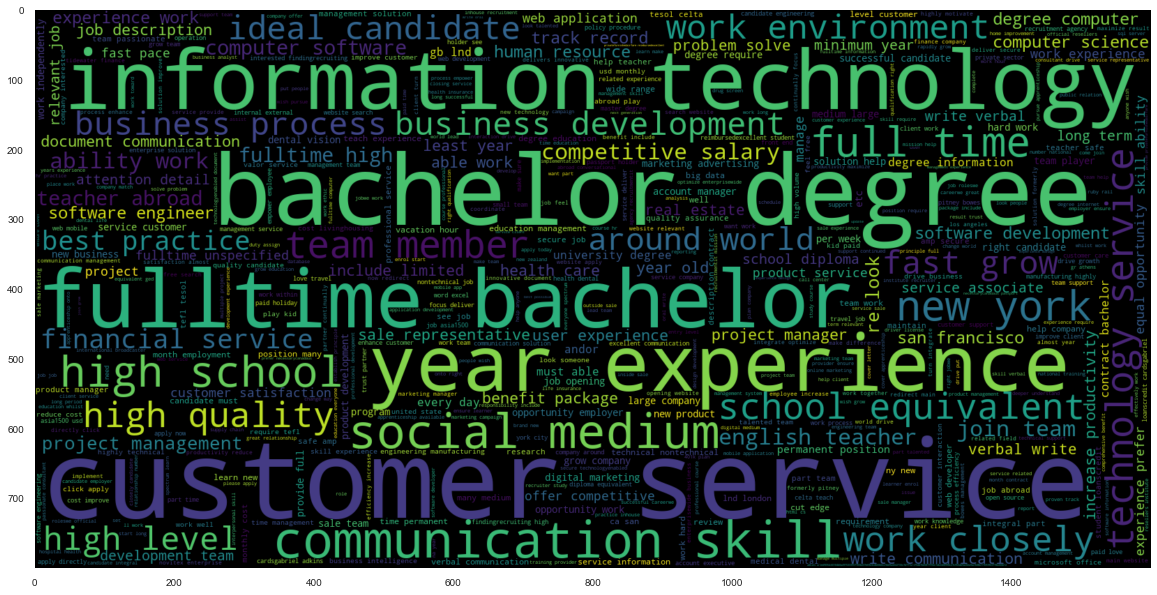

In [22]:
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(job_df[job_df.fraudulent == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

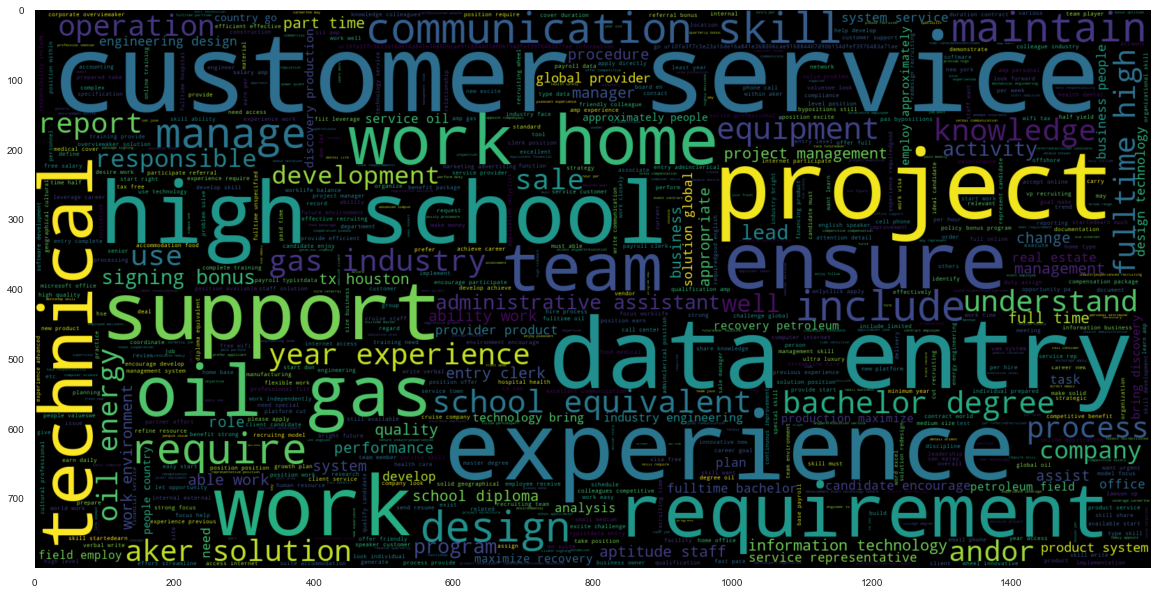

In [23]:
plt.figure(figsize = (20,20)) # Text that is fraudulent(1)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(job_df[job_df.fraudulent == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(job_df, job_df['fraudulent'], test_size=0.10, 
                                                    random_state=0, stratify= job_df['fraudulent'])

#### numerical features

In [26]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack,csr_matrix

num_features = ['telecommuting', 'has_company_logo', 'has_questions']

scaler=StandardScaler()

# we convert this features into csr_mtarix to match cv or tfidf vectorizer sparse matrix
num_train=csr_matrix(scaler.fit_transform(X_train[num_features]))
num_test=csr_matrix(scaler.transform(X_test[num_features]))

#### text features

In [27]:
# using CountVectorizer to convert text to word count vectors
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1,2))
cv_text_train= cv.fit_transform(X_train['text'])
cv_text_test= cv.transform(X_test['text'])

In [28]:
# using TfidfVectorizer to convert text to word frequency vectors
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(ngram_range=(1,2))
tfidf_text_train=tfidf.fit_transform(X_train['text'])
tfidf_text_test=tfidf.transform(X_test['text'])

#### combine them

In [29]:
cv_combined_train=hstack([num_train,cv_text_train])
cv_combined_test=hstack([num_test,cv_text_test])

tfidf_combined_train=hstack([num_train,tfidf_text_train])
tfidf_combined_test=hstack([num_test,tfidf_text_test])

### KNN with CountVectorizer

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
param_grid = dict(n_neighbors = k_range, weights = weight_options)
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'f1')
grid.fit(cv_combined_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

print(f1_score(y_test,grid.predict(cv_combined_test)))
print(confusion_matrix(y_test,grid.predict(cv_combined_test)))

0.6467065868263472
[[1669   27]
 [  32   54]]


In [32]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.6610101750628077
{'n_neighbors': 18, 'weights': 'distance'}
KNeighborsClassifier(n_neighbors=18, weights='distance')


### KNN with TfidfVectorizer

In [33]:
k_range = list(range(1,31))
weight_options = ["uniform", "distance"]
param_grid = dict(n_neighbors = k_range, weights = weight_options)
knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv = 10, scoring = 'f1')
grid.fit(tfidf_combined_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [34]:
print(f1_score(y_test,grid.predict(tfidf_combined_test)))
print(confusion_matrix(y_test,grid.predict(tfidf_combined_test)))

0.8771929824561403
[[1686   10]
 [  11   75]]


In [35]:
print (grid.best_score_)
print (grid.best_params_)
print (grid.best_estimator_)

0.8296641421558213
{'n_neighbors': 4, 'weights': 'distance'}
KNeighborsClassifier(n_neighbors=4, weights='distance')


#### score comparison

In [36]:
knn_cv_report = classification_report(y_test,grid.predict(cv_combined_test),target_names = ['real','fraud'])
print(knn_cv_report)
knn_tfidf_report = classification_report(y_test,grid.predict(tfidf_combined_test),target_names = ['real','fraud'])
print(knn_tfidf_report)

              precision    recall  f1-score   support

        real       0.99      0.99      0.99      1696
       fraud       0.86      0.84      0.85        86

    accuracy                           0.99      1782
   macro avg       0.92      0.92      0.92      1782
weighted avg       0.99      0.99      0.99      1782

              precision    recall  f1-score   support

        real       0.99      0.99      0.99      1696
       fraud       0.88      0.87      0.88        86

    accuracy                           0.99      1782
   macro avg       0.94      0.93      0.94      1782
weighted avg       0.99      0.99      0.99      1782



### Logistic Regression with CountVectorizer

In [37]:
from sklearn.linear_model import LogisticRegression

params={'C':[1,10,100,1000]}
lgr =LogisticRegression(solver='liblinear',class_weight='balanced')
grid=GridSearchCV(lgr,params,scoring='f1',n_jobs=-1,cv=5)
grid.fit(cv_combined_train,y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          solver='liblinear'),
             n_jobs=-1, param_grid={'C': [1, 10, 100, 1000]}, scoring='f1')

In [40]:
print(f1_score(y_test,grid.predict(cv_combined_test)))
print(confusion_matrix(y_test,grid.predict(cv_combined_test)))

0.9176470588235294
[[1690    6]
 [   8   78]]


### Logistic Regression with TfidfVectorizer

In [41]:
params={'C':[1,10,100,1000]}
lgr =LogisticRegression(solver='liblinear',class_weight='balanced')
grid=GridSearchCV(lgr,params,scoring='f1',n_jobs=-1,cv=5)
grid.fit(tfidf_combined_train,y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          solver='liblinear'),
             n_jobs=-1, param_grid={'C': [1, 10, 100, 1000]}, scoring='f1')

In [42]:
print(f1_score(y_test,grid.predict(tfidf_combined_test)))
print(confusion_matrix(y_test,grid.predict(tfidf_combined_test)))

0.9152542372881357
[[1686   10]
 [   5   81]]


#### score comparison

In [43]:
knn_cv_report = classification_report(y_test,grid.predict(cv_combined_test),target_names = ['real','fraud'])
print(knn_cv_report)
knn_tfidf_report = classification_report(y_test,grid.predict(tfidf_combined_test),target_names = ['real','fraud'])
print(knn_tfidf_report)

              precision    recall  f1-score   support

        real       1.00      0.93      0.96      1696
       fraud       0.40      0.95      0.57        86

    accuracy                           0.93      1782
   macro avg       0.70      0.94      0.76      1782
weighted avg       0.97      0.93      0.94      1782

              precision    recall  f1-score   support

        real       1.00      0.99      1.00      1696
       fraud       0.89      0.94      0.92        86

    accuracy                           0.99      1782
   macro avg       0.94      0.97      0.96      1782
weighted avg       0.99      0.99      0.99      1782



since we have imbalance dataset, then the f1 score is more fitted metric. the best f1-score is 0.92 by logistic regression with tfidf vectorizer. turns out only text features vs combined (text + numeric) features are merely the same, not much differences.